# Lab: Missing Female Age and Imputation Distortion (Titanic)

This lab reproduces a common data-mining pitfall:
**naive imputation of missing ages can strongly distort subgroup distributions**.

Dataset: `data/titanic.csv` (open-source Titanic passenger data).


## 1. Setup


In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error
from scipy.stats import wasserstein_distance

RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)
sns.set_theme(style='whitegrid', context='notebook')


## 2. Load Dataset


In [2]:
df = pd.read_csv('data/titanic.csv')

# Extract title from passenger name (Mr, Miss, Mrs, etc.)
def extract_title(name):
    m = re.search(r',\s*([^\.]+)\.', str(name))
    return m.group(1).strip() if m else 'Unknown'

df['Title'] = df['Name'].map(extract_title)

print('Shape:', df.shape)
print('Columns:', list(df.columns))
print('Overall missing Age rate: {:.1%}'.format(df['Age'].isna().mean()))
df.head()


Shape: (891, 13)
Columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title']
Overall missing Age rate: 19.9%


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


#### Output Analysis
- Titanic has substantial missingness in `Age` (~20%).
- We also derive `Title`, which is often useful for stratified imputation.
- This dataset is ideal for demonstrating age-imputation bias.


## 3. Missingness by Sex and Title


In [3]:
missing_by_sex = df.groupby('Sex')['Age'].apply(lambda s: s.isna().mean()).sort_values(ascending=False)
missing_by_title = df.groupby('Title')['Age'].apply(lambda s: s.isna().mean()).sort_values(ascending=False)

print('Missing Age by Sex:')
print((100 * missing_by_sex).round(1).astype(str) + '%')
print('')
print('Top titles by missing Age rate:')
print((100 * missing_by_title.head(12)).round(1).astype(str) + '%')


Missing Age by Sex:
Sex
male      21.5%
female    16.9%
Name: Age, dtype: str

Top titles by missing Age rate:
Title
Mr        23.0%
Miss      19.8%
Dr        14.3%
Mrs       13.6%
Master    10.0%
Mme        0.0%
Sir        0.0%
Rev        0.0%
Ms         0.0%
Capt       0.0%
Mlle       0.0%
Col        0.0%
Name: Age, dtype: str


#### Output Analysis
- Missingness is not uniform across demographic groups/titles.
- Non-random missingness is where naive imputation usually fails.
- We will stress-test this effect specifically on women.


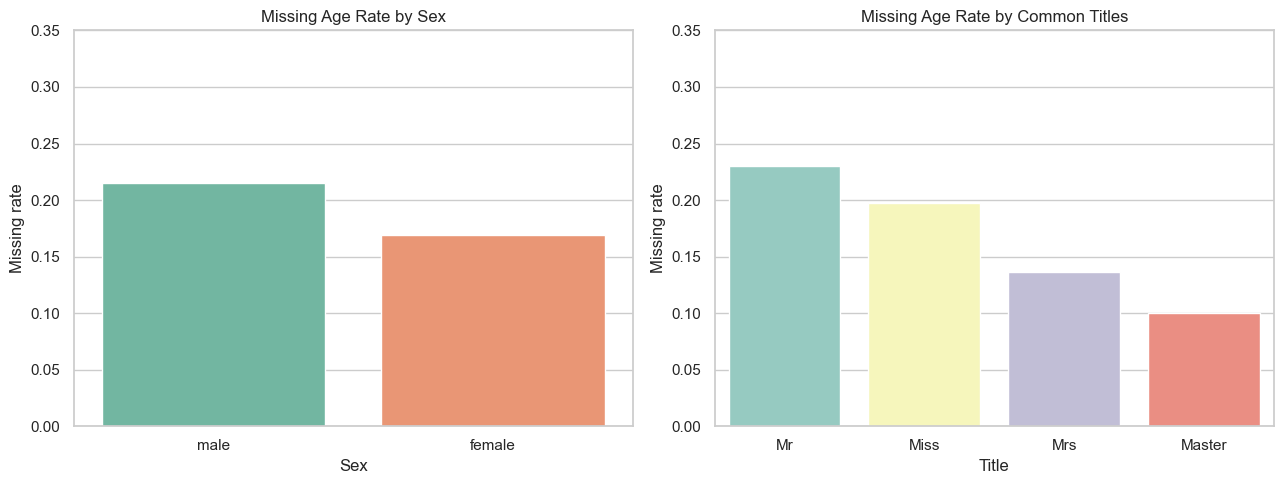

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

sns.barplot(x=missing_by_sex.index, y=missing_by_sex.values, ax=axes[0], palette='Set2', hue=missing_by_sex.index, legend=False)
axes[0].set_title('Missing Age Rate by Sex')
axes[0].set_ylabel('Missing rate')
axes[0].set_ylim(0, 0.35)

title_subset = ['Mr', 'Miss', 'Mrs', 'Master']
title_rates = missing_by_title.reindex(title_subset).fillna(0)
sns.barplot(x=title_rates.index, y=title_rates.values, ax=axes[1], palette='Set3', hue=title_rates.index, legend=False)
axes[1].set_title('Missing Age Rate by Common Titles')
axes[1].set_ylabel('Missing rate')
axes[1].set_ylim(0, 0.35)

plt.tight_layout()
plt.show()


#### Output Analysis
- Visual comparison confirms subgroup differences in missing age rates.
- `Miss`/`Mrs` can have different missingness behavior from `Mr`.
- This motivates subgroup-aware imputation rather than one global value.


## 4. Create a Controlled Female-Missingness Scenario

To evaluate imputation quality, we need ground truth.
So we intentionally hide some **known female ages** and then check how well each method recovers them.


In [5]:
df_sim = df.copy()

female_obs_idx = df_sim.index[(df_sim['Sex'] == 'female') & (df_sim['Age'].notna())]

# Hide 60% of observed female ages to simulate stronger missingness in women
hide_frac = 0.60
n_hide = int(len(female_obs_idx) * hide_frac)
hidden_idx = rng.choice(female_obs_idx, size=n_hide, replace=False)

true_hidden_age = df_sim.loc[hidden_idx, 'Age'].copy()
df_sim.loc[hidden_idx, 'Age'] = np.nan

print('Female observed ages before hiding:', len(female_obs_idx))
print('Female ages hidden for evaluation:', n_hide)
print('Female missing rate after hiding: {:.1%}'.format(df_sim.loc[df_sim['Sex']=='female', 'Age'].isna().mean()))


Female observed ages before hiding: 261
Female ages hidden for evaluation: 156
Female missing rate after hiding: 66.6%


#### Output Analysis
- We now have a realistic "women age omitted" scenario with known true ages for evaluation.
- This lets us compare imputation methods objectively (MAE) and distributionally.
- The setup mimics CV-like selective age omission behavior.


## 5. Imputation Methods

We compare:
1. Global median age
2. Sex-specific median age
3. Title + class median (fallback to sex median, then global median)
4. KNN imputation using related numeric/categorical signals


In [6]:
def impute_global_median(df_in):
    out = df_in.copy()
    out['Age_imp'] = out['Age'].fillna(out['Age'].median())
    return out


def impute_sex_median(df_in):
    out = df_in.copy()
    out['Age_imp'] = out['Age']
    out['Age_imp'] = out.groupby('Sex')['Age_imp'].transform(lambda s: s.fillna(s.median()))
    out['Age_imp'] = out['Age_imp'].fillna(out['Age'].median())
    return out


def impute_title_pclass(df_in):
    out = df_in.copy()
    out['Age_imp'] = out['Age']

    # group median on (Sex, Title, Pclass)
    group_med = out.groupby(['Sex', 'Title', 'Pclass'])['Age_imp'].transform('median')
    out['Age_imp'] = out['Age_imp'].fillna(group_med)

    # fallback: sex median
    sex_med = out.groupby('Sex')['Age_imp'].transform('median')
    out['Age_imp'] = out['Age_imp'].fillna(sex_med)

    # fallback: global median
    out['Age_imp'] = out['Age_imp'].fillna(out['Age'].median())
    return out


def impute_knn(df_in):
    out = df_in.copy()

    work = out[['Age', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Sex']].copy()
    work['Sex_code'] = (work['Sex'] == 'male').astype(int)
    work = work.drop(columns=['Sex'])

    imputer = KNNImputer(n_neighbors=7)
    arr = imputer.fit_transform(work)

    out['Age_imp'] = arr[:, 0]
    return out


In [7]:
imputed = {
    'global_median': impute_global_median(df_sim),
    'sex_median': impute_sex_median(df_sim),
    'title_pclass': impute_title_pclass(df_sim),
    'knn': impute_knn(df_sim),
}

for name, dfi in imputed.items():
    assert dfi['Age_imp'].isna().sum() == 0, f'{name} still has missing ages'

print('All imputers produced complete Age_imp values.')


All imputers produced complete Age_imp values.


#### Output Analysis
- Each method now yields a complete age column (`Age_imp`).
- Next we compare both point accuracy (on hidden true ages) and distribution distortion.


## 6. Evaluate Recovery Error on Hidden Female Ages


In [8]:
rows = []
for name, dfi in imputed.items():
    pred_hidden = dfi.loc[hidden_idx, 'Age_imp']
    mae = mean_absolute_error(true_hidden_age, pred_hidden)

    rows.append({'method': name, 'hidden_female_mae': mae})

mae_table = pd.DataFrame(rows).sort_values('hidden_female_mae')
mae_table


,method,hidden_female_mae
2,title_pclass,9.636218
0,global_median,10.552885
3,knn,10.685760
1,sex_median,11.693910


#### Output Analysis
- Lower MAE means better age recovery for women with hidden ages.
- Group-aware methods often outperform global single-value fills.
- But error alone does not capture distribution shape distortion.


## 7. Measure Distribution Distortion for Female Ages

Compare each imputed female age distribution against the **true female age distribution**.


In [9]:
female_true = df.loc[df['Sex'] == 'female', 'Age'].dropna()

dist_rows = []
for name, dfi in imputed.items():
    female_imp = dfi.loc[dfi['Sex'] == 'female', 'Age_imp'].dropna()
    wd = wasserstein_distance(female_true, female_imp)

    # spike ratio: share exactly at median-ish imputed value (rough indicator of collapse)
    med = np.median(female_imp)
    spike_ratio = np.mean(np.isclose(female_imp, med, atol=1e-9))

    dist_rows.append({'method': name, 'wasserstein_distance': wd, 'median_spike_ratio': spike_ratio})

dist_table = pd.DataFrame(dist_rows).sort_values('wasserstein_distance')
dist_table


,method,wasserstein_distance,median_spike_ratio
3,knn,2.732714,0.009554
2,title_pclass,4.548567,0.105096
0,global_median,7.145438,0.668790
1,sex_median,7.780221,0.675159


#### Output Analysis
- Lower Wasserstein distance means the imputed female distribution is closer to the true one.
- High median-spike ratio indicates collapsed distributions from constant-value imputation.
- This is the key risk: acceptable MAE can still hide severe distribution shift.


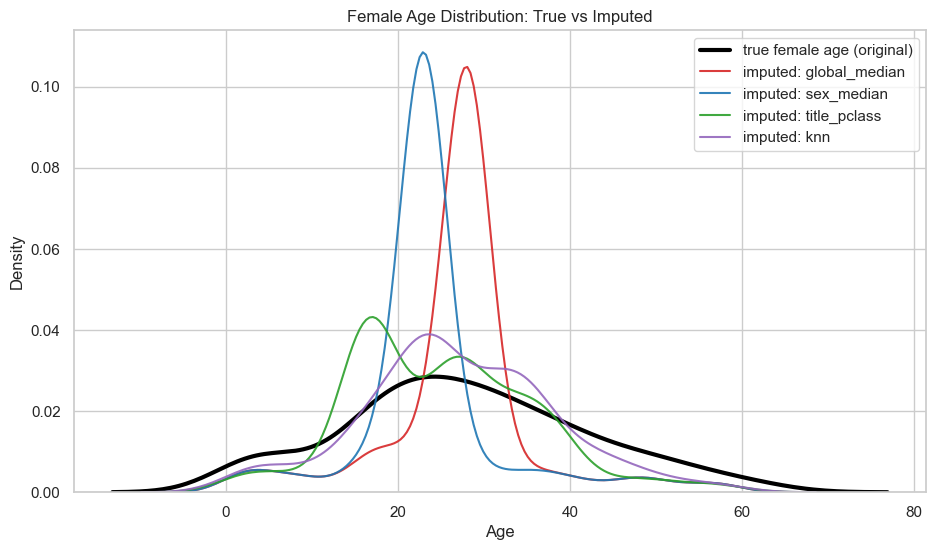

In [10]:
plt.figure(figsize=(11, 6))

sns.kdeplot(female_true, label='true female age (original)', linewidth=3, color='black')

palette = {
    'global_median': '#d62728',
    'sex_median': '#1f77b4',
    'title_pclass': '#2ca02c',
    'knn': '#9467bd',
}

for name, dfi in imputed.items():
    female_imp = dfi.loc[dfi['Sex'] == 'female', 'Age_imp'].dropna()
    sns.kdeplot(female_imp, label=f'imputed: {name}', color=palette[name], alpha=0.9)

plt.title('Female Age Distribution: True vs Imputed')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()


#### Output Analysis
- Global/sex median methods usually create visible spikes and flatten natural age structure.
- Title/class-aware and KNN methods often preserve smoother, more realistic female age patterns.
- This demonstrates how imputation choice can drastically change subgroup distribution.


## 8. Optional: Why This Matters for Modeling

Even if accuracy changes only a bit, distorted feature distributions can bias downstream decisions,
segment analysis, and fairness conclusions for women-specific subgroups.


## 9. Student Tasks (10 Variants)

### Variant 1
1. Change hidden female fraction from 60% to 30% and 80%.
2. Compare MAE ranking changes.
3. Explain robustness of each method.

### Variant 2
1. Use global **mean** instead of median.
2. Compare distribution spikes and Wasserstein distance.
3. Decide which global strategy is less harmful.

### Variant 3
1. Modify title groups: merge rare titles into `Rare`.
2. Re-run title+pclass imputation.
3. Check if stability improves.

### Variant 4
1. Try KNN with `k=3`, `k=7`, `k=15`.
2. Compare MAE and Wasserstein.
3. Choose best tradeoff.

### Variant 5
1. Add `Embarked` and `Cabin` indicators to KNN features.
2. Evaluate whether extra features help.
3. Explain any performance changes.

### Variant 6
1. Hide ages mostly for `Miss` passengers only.
2. Compare method ranking vs base scenario.
3. Explain subgroup sensitivity.

### Variant 7
1. Hide ages mostly for older women (`Age > 35`).
2. Recompute MAE and distribution metrics.
3. Explain why MAR patterns matter.

### Variant 8
1. Compare female and male distortion metrics side-by-side.
2. Identify whether one sex is more affected.
3. Summarize fairness implications.

### Variant 9
1. Build a survival model with each imputed age column.
2. Compare model metrics.
3. Check if better predictive score always means less distortion.

### Variant 10
1. Create one final recommendation table (method vs metrics).
2. Pick a default imputation method for this dataset.
3. Write a short policy note for analysts.
